In [111]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import MDAnalysis as md
import seaborn as sns
import scipy as sci

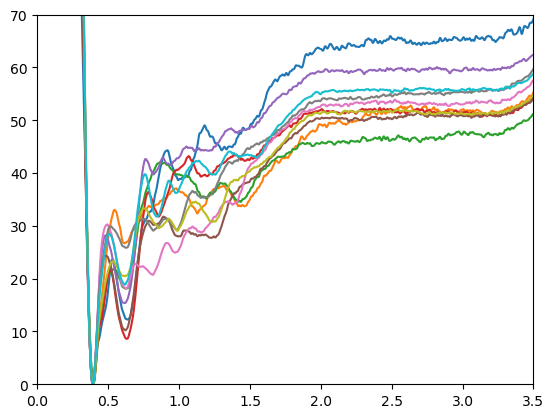

In [112]:
#SUM_HILLS
#checking progress of calculation
#plot the development of the fes as a function of time
#launch a sum_hills calculation with plumed using as input your HILLS file.
#This is the line used to create the fes found in data/post-processing/fes
# 
#plumed sum_hills --hills HILLS_800ns --mintozero --stride 80000
for i in range(10):
  data = np.loadtxt('./data/post-processing/fes/fes_{0}.dat'.format(i), comments='#', unpack=True)
  plt.plot(data[0], data[1])
  plt.axis([0, 3.5, 0, 70])
plt.show()

In [113]:
#plot 1D or 2D FES
########## Select here plot type (simple, surface, or contour) ###########
plot_type = 'contour'
############################################
#Minimum value of the fes (if you used mintozero option in the sum_hills command then set to 0)
min_fes = 0
#Maximum value of the fes in the explored phase space
max_fes = 70
#Contour plot resolution, default kJ/mol
contour_stride = 5

data = np.loadtxt("./data/post-processing/2D-distance.dat", comments="#", unpack=True)
nbins_cv1 = int(np.loadtxt("./data/post-processing/2D-distance.dat", unpack=True,
                       skiprows=3, max_rows=1, comments=None, dtype=str, usecols=(3)))
cv1 = data[0]

if plot_type == "surface" or plot_type == "contour":
    cv2 = data[1]
    energy = data[2]
    e_lims = np.reshape(energy, (-1, nbins_cv1))
    cv1_lims = np.linspace(np.min(cv1), np.max(cv1), e_lims.shape[1])
    cv2_lims = np.linspace(np.min(cv2), np.max(cv2), e_lims.shape[0])
else:
    energy = data[1]
    e_lims = energy

#3D view of the 2D free-energy surface
if plot_type == "surface":
    fig = go.Figure(data=[go.Surface(z=e_lims, x=cv1_lims, y=cv2_lims, cmin=min_fes, cmax=max_fes)])
    fig.update_layout(
    scene = dict(zaxis = dict(nticks=4, range=[min_fes,max_fes],),))
    fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True, size=0.05))
    fig.show()

#Map view of the previous graph

elif plot_type == "contour":
    fig = go.Figure(data=go.Contour(z=e_lims, x=cv1_lims, y=cv2_lims, contours=dict(start=min_fes, end=max_fes, size=contour_stride)))
    fig.show()

else:
    plt.plot(cv1, energy)
    plt.show()

In [114]:
#Switch mode to '2D' if your interested in extracting frames from 2 collective variables
#Important! The trajectory and the COLVAR file MUST have the same amount of data points
mode = '1D'
# Load the trajectory and topology
u = md.Universe("data/post-processing/start.pdb", "data/post-processing/trj.trr")

# Load the COLVAR file
colvar_data = np.loadtxt("data/post-processing/COLVAR", comments='#', unpack=True)

# Get the CV values from the COLVAR file
cv1 = colvar_data[:, 1]  # Replace 1 with the column index for your first CV
if mode == '2D':
  cv2 = colvar_data[:, 2]  # Replace 2 with the column index for your second CV

# Define the selection criteria
# Example: Extract frames where cv1 is between 2 and 3
selection_indices = np.where((cv1 > 0.36) & (cv1 < 1.5))
if mode == '2D':
  selection_indices = np.where((cv1 > 0.36) & (cv1 < 1.5) & (cv2 > 2.19) & (cv2 < 2.95))

# Extract the frames
for i in selection_indices[0]:
  # Set the time step to the desired frame
  u.trajectory[i]
  # Save the frame to a file
  with md.Writer("extracted_frames.xtc", u.atoms.n_atoms) as W:
    W.write(u)

/usr/local/anaconda3/envs/FM_tutorial/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning:

Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.



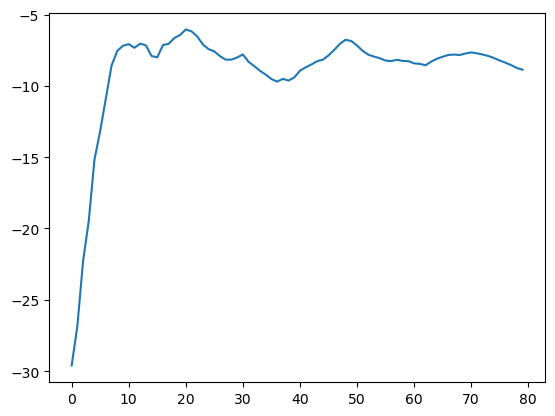

In [122]:
beta = (8.314*10**(-3)*300)**-1

#Wref should be the value of the free energy related to a certain cv value chosen by the user
#This value should represent the distance in the unbound state.
ref=2.75

mode == '1D'

Gt = []
for j in range(0,11):
    #data = np.loadtxt("data/post-processing/fes/fes_{0}.dat".format(j), comments="#", unpack=True)
    data = np.loadtxt("/Users/Sannian/Downloads/FMAP/Supplementary_data_2/BFES/fes_{0}.dat".format(j), comments="#", unpack=True)
    cv1 = data[0]
    dcv1 = cv1[1] - cv1[0]
    energy = data[1]
    if mode == '2D':
      cv2 = data[1]
      dcv2 = cv2[nbins_cv1+1] - cv2[0]
      energy = data[2]

    if mode == '2D':
      x = np.where((0.36 <= cv1) & (cv1 <= 0.42) & (cv2 >= 2.15) & (cv2 <= 2.95))
    else:
      x = np.where((0.36 <= cv1) & (cv1 <= 0.42))

    fez = [energy[i] for i in x[0]]

    fez = np.array(fez)
    #For 2D you might want to adapt the code to allow "ref" to take a 2D interval instead
    w = -beta*(fez - energy[np.where(abs(data[0]-ref) < dcv1/2)])
    mid = [np.exp(w[0])]
    for i in range(1, len(w)-1):
        mid.append(2*np.exp(w[i]))
    mid.append(np.exp(w[-1]))
    mid = (dcv1/2)*np.sum(np.array(mid))
    if mode == '2D':
      mid *= dcv2/2
    kb = np.pi*(0.1**2)*mid
    G = -(1/beta)*np.log(0.6*kb)
    Gt.append(G*0.239)
plt.plot(Gt, label='G(t)')
plt.show()

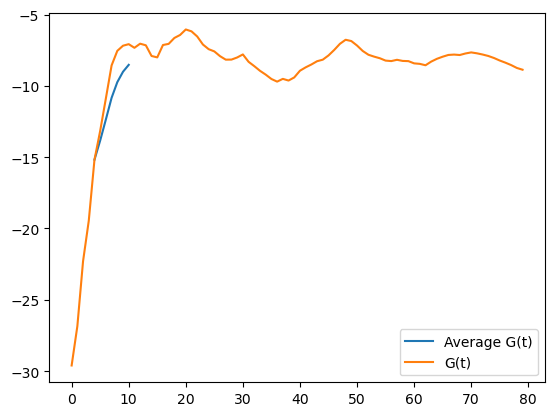

In [125]:
rej_time = 5
avgG = []
for i in range(rej_time, 12):
    subGt = Gt[rej_time-1:i]
    w = np.zeros_like(subGt)
    for j in range(1, len(subGt) + 1):
        w[j - 1] = j / len(subGt)
    wsubGt = w * np.array(subGt)
    avgG.append(np.sum(wsubGt) / np.sum(w))
plt.plot(np.arange(rej_time-1,11), avgG, label="Average G(t)")
plt.plot(Gt, label='G(t)')
plt.legend()
plt.show()

Slice 0 has a distribution with mu and sigma: -18.24, 0.23
Slice 1 has a distribution with mu and sigma: -7.41, 0.01
Slice 2 has a distribution with mu and sigma: -6.64, 0.01
Slice 3 has a distribution with mu and sigma: -7.92, 0.01
Slice 4 has a distribution with mu and sigma: -9.32, 0.01
Slice 5 has a distribution with mu and sigma: -8.12, 0.02
Slice 6 has a distribution with mu and sigma: -7.55, 0.02
Slice 7 has a distribution with mu and sigma: -8.34, 0.00
Slice 8 has a distribution with mu and sigma: -7.83, 0.00
Slice 9 has a distribution with mu and sigma: -8.31, 0.01


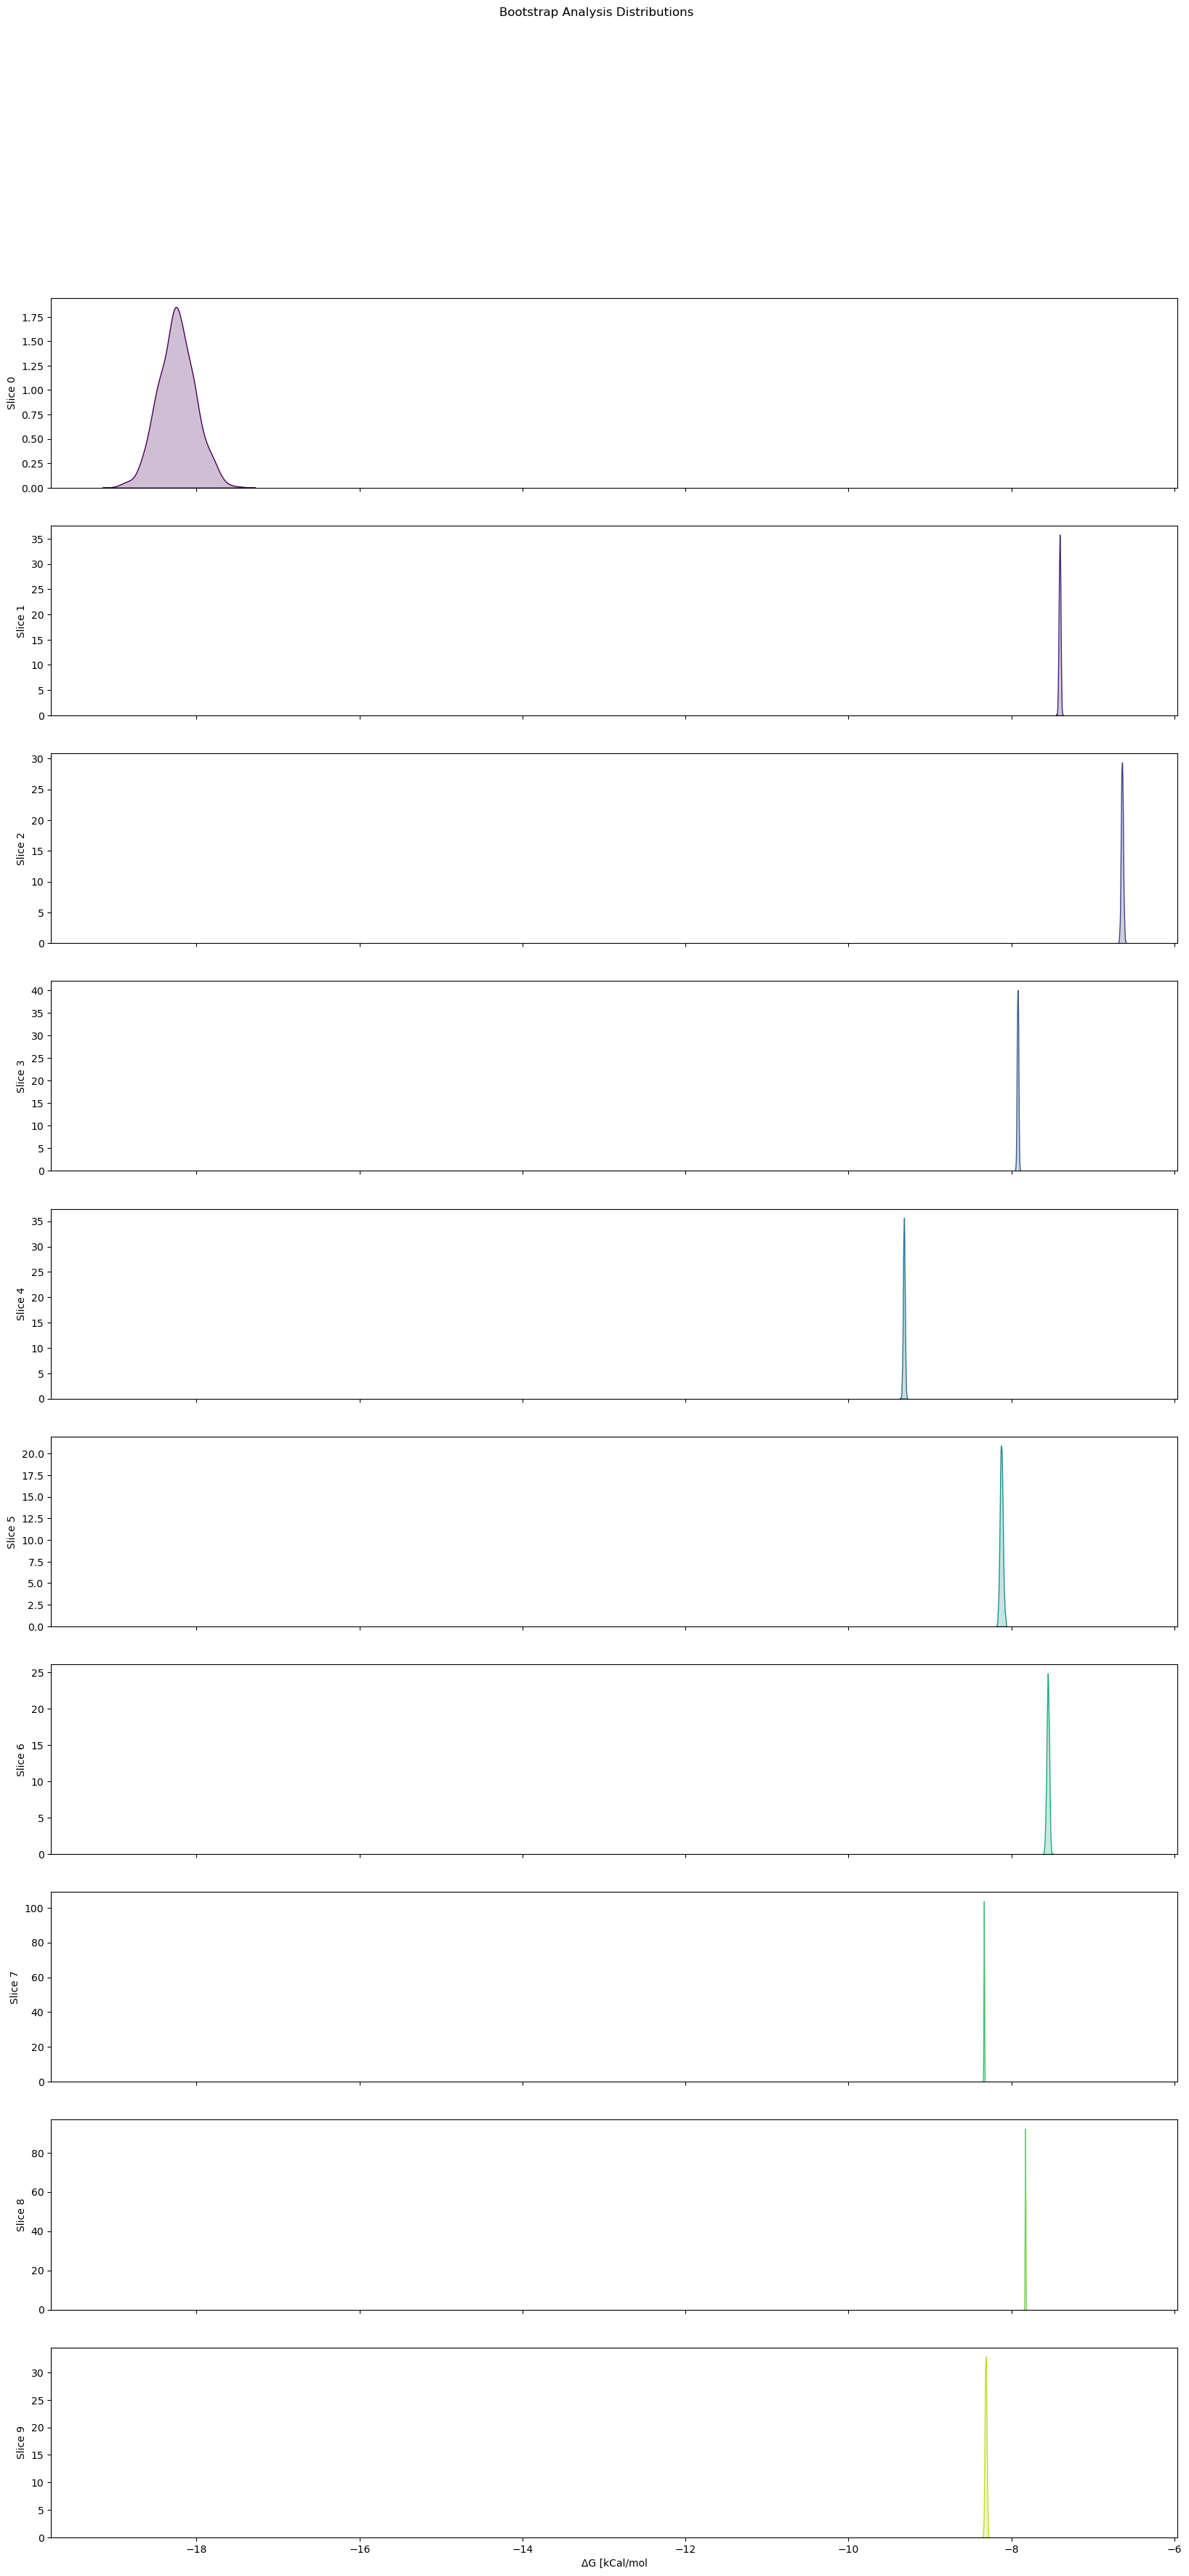

In [126]:
#number of gaussian distributions that you wish to obtain at the end
slices = 10
#Initial time from which to calculate the bootstrap
init_t = 0
data_dict = {}
#number of times to randomly sample from the data subset
Gt = Gt[init_t:]
n_samples = 1000
bootstraps = np.zeros((slices, n_samples))
Gt = np.array(Gt)
#iterate through the data subsets
for i in range(1, slices+1):
    #generate the min and max of the ith data subset
    ranges = np.arange(int((len(Gt)/slices)*(i-1)), int((len(Gt)/slices)*i))
    #randomly choose n_samples from the slice
    for j in range(n_samples):
        indices = np.random.choice(ranges, size=1000, replace=True)
        bootstraps[i - 1][j] = (np.average(Gt[indices]))
#plot the distributions of all obtained data sets
for i in range(slices):
  print("Slice {0} has a distribution with mu and sigma: {1:.2f}, {2:.2f}".format(i, np.average(bootstraps[i]), np.std(bootstraps[i])))
  data_dict.update({'Slice {0}'.format(i) : bootstraps[i]})

fig, axes = plt.subplots(len(data_dict), 1, sharex=True, sharey=False, figsize=(20,40))
# Iterate through the distributions
for i, (name, data) in enumerate(data_dict.items()):
    # Plot the distribution
    sns.kdeplot(data, ax=axes[i], fill=True, common_norm=False, legend=False, color=plt.cm.viridis(i / len(data_dict)))
    axes[i].set_ylabel(name)
    # Set the title and labels
plt.xlabel("ΔG [kCal/mol")
plt.suptitle("Bootstrap Analysis Distributions")
plt.show()